In [38]:
from gensim.models.doc2vec import Doc2Vec
import gensim
from sklearn.metrics import mean_absolute_error

In [1]:
import sys
import csv
import pandas as pd
import string
from string import maketrans 
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [2]:
import pandas as pd
from pandas_summary import DataFrameSummary
from sklearn.externals import joblib

In [94]:
from sklearn.linear_model import Lasso, LassoCV
from keras.models import load_model
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, Dropout, BatchNormalization
from keras import backend as K
from keras.models import load_model
from keras import metrics

In [4]:
wordnet_lemmatizer = WordNetLemmatizer()

In [5]:
df_train = pd.read_csv('Train_rev1.csv')

In [6]:
df_train = df_train[['FullDescription', 'SalaryNormalized']]
df_train.columns = [['message', 'salary']]

In [7]:
df_train = df_train.reset_index(drop = True)

In [8]:
def text_process(s):
    s = str(s)
    s = s.translate(None, string.punctuation)
    s = s.translate(None, '1234567890')
    s = [word for word in s.split() if not (word.startswith('http'))]
    s = ' '.join(s)
    s = re.sub(' +',' ',s)
    s = s.decode('ascii', 'ignore')
    s = s.lower()
    s = [word for word in s.split() if word not\
         in stopwords.words('english') + ['k']]
    s = [wordnet_lemmatizer.lemmatize(word) for word in s]
    sentence = ' '.join(s)
    return sentence

In [ ]:
messages = df_train['message'].values
n_message = len(messages)
token_values = np.zeros(n_message).astype(str)
for idx in tqdm(range(n_message)):
    token_values[idx] = text_process(messages[idx])

In [ ]:
from sklearn.externals import joblib
joblib.dump(token_values, 'token_values.pkl')

In [9]:
token_values = joblib.load('token_values.pkl')

In [10]:
token_values

array(['engineering system analyst dorki',
       'stress engineer glasgow salary c',
       'mathematical modeller simulation', ...,
       'position qualified teacher subje',
       'position qualified teacher subje',
       'entrepreneurial growing private '], dtype='|S32')

In [162]:
words =  ''

for idx in range(len(token_values)):
    words += '' + str(token_values[idx])

In [166]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=600, height=400).generate(words)

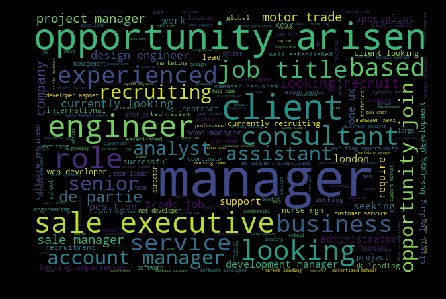

In [168]:
plt.figure( figsize=(6,5), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [11]:
Y_full = df_train['salary'].values.astype(float).reshape(-1)

In [12]:
from sklearn.metrics import make_scorer

def mape_loss_func(labels, preds):
    err = 100. * np.mean(np.abs(1. - np.true_divide(preds, labels))) 
    return err

mape_loss  = make_scorer(mape_loss_func, 
                          greater_is_better=False)

def mape_xgboost(preds, dtrain):
    labels = dtrain.get_label()
    err =  100. * np.mean(np.abs(1. - np.true_divide(preds, labels))) 
    return 'error', err

In [74]:
idx_train, idx_test = train_test_split(np.arange(len(Y_full)), test_size = 0.30, random_state = 1234)

In [75]:
Y_train, Y_test = Y_full[idx_train], Y_full[idx_test]

# Base Model

In [76]:
mape_loss_func(Y_test, np.tile(Y_train.mean(), len(Y_test)))

49.08273120444054

# TF-IDF

In [123]:
count_vectorizer = TfidfVectorizer()
X_full = count_vectorizer.fit_transform(token_values)

In [124]:
X_train, X_test = X_full[idx_train], X_full[idx_test]

In [125]:
print X_full.shape
print Y_full.shape

(244768, 31444)
(244768,)


In [115]:
lasso_count_model = Lasso(normalize = True)
lasso_count_model.fit(X_train, Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [116]:
mape_loss_func(Y_test, lasso_count_model.predict(X_test))

42.974332976841254

In [121]:
inputs = Input(shape = (X_train.shape[1],), name='Input')
X = BatchNormalization(name = 'BN0')(inputs)
X = Dense(1000,  activation='relu', name='Dense1')(X)
X = BatchNormalization(name = 'BN1')(X)
X = Dropout(0.2, name = 'Drop1')(X)
X = Dense(1, activation = 'relu', name = 'prediction')(X)

tfidf_nn = Model(inputs, X, name='tfidf_nn')
tfidf_nn.compile('adam', 'mean_absolute_error', [metrics.mae])
tfidf_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 31444)             0         
_________________________________________________________________
BN0 (BatchNormalization)     (None, 31444)             125776    
_________________________________________________________________
Dense1 (Dense)               (None, 1000)              31445000  
_________________________________________________________________
BN1 (BatchNormalization)     (None, 1000)              4000      
_________________________________________________________________
Drop1 (Dropout)              (None, 1000)              0         
_________________________________________________________________
prediction (Dense)           (None, 1)                 1001      
Total params: 31,575,777
Trainable params: 31,510,889
Non-trainable params: 64,888
___________________________________________________________

In [126]:
tfidf_nn.fit(X_train, Y_train, batch_size= 32, epochs=2)

Epoch 1/2
171337/171337 [==============================] - 2676s 16ms/step - loss: 21701.7990 - mean_absolute_error: 21701.7990
Epoch 2/2
171337/171337 [==============================] - 2043s 12ms/step - loss: 11184.2262 - mean_absolute_error: 11184.2262


In [127]:
mape_loss_func(Y_test, tfidf_nn.predict(X_test, batch_size=32, verbose =1).reshape(-1))

73431/73431 [==============================] - 90s 1ms/step


47.66675960276085

In [119]:
tfidf_nn.save('tfidf_nn.h5')

# Doc2Vec

In [132]:
token_index = ['doc_' + str(x) for x in np.arange(len(token_values))]
token_index[:5]

['doc_0', 'doc_1', 'doc_2', 'doc_3', 'doc_4']

In [133]:
class LabeledLineSentence(object):
    def __init__(self, token_index, token_values):
        self.token_index = token_index
        self.token_values = token_values
        self.n_token = len(token_values)
        
    def __iter__(self):
        for idx in range(self.n_token):
            yield gensim.models.doc2vec.LabeledSentence(words= self.token_values[idx].split(),tags=[self.token_index[idx]])

In [134]:
gen = LabeledLineSentence(token_index, token_values)

In [135]:
model = gensim.models.Doc2Vec(size=1000, window=10, min_count=5, workers=8, alpha=0.025, min_alpha=0.025) 
model.build_vocab(gen)

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if __name__ == '__main__':


In [136]:
for epoch in tqdm(range(10)):
    model.train(gen, total_examples = model.corpus_count, epochs = 1)
    model.alpha -= 0.002 
    model.min_alpha = model.alpha

  0%|          | 0/10 [00:00<?, ?it/s]/home/adityasidharta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if __name__ == '__main__':
100%|██████████| 10/10 [04:41<00:00, 28.20s/it]


In [99]:
model.most_similar('great')

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('amazing', 0.7279897928237915),
 ('brilliant', 0.7134158611297607),
 ('superb', 0.7132153511047363),
 ('fantastic', 0.6837238073348999),
 ('fabulous', 0.6799948811531067),
 ('excellent', 0.6740776896476746),
 ('incredible', 0.6696920394897461),
 ('wonderful', 0.6357823014259338),
 ('exciting', 0.6275373697280884),
 ('unique', 0.6078590154647827)]

In [100]:
model.most_similar('engineer')

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('modeller', 0.5226564407348633),
 ('draughtsman', 0.5153059363365173),
 ('cable', 0.5147504806518555),
 ('technician', 0.4939102828502655),
 ('installer', 0.49100038409233093),
 ('inspector', 0.490485817193985),
 ('fitter', 0.4816894233226776),
 ('engine', 0.4813685417175293),
 ('draughtsperson', 0.48029792308807373),
 ('layer', 0.47212496399879456)]

In [137]:
X_full = np.zeros((len(Y_full), 1000))
for idx in range(X_full.shape[0]):
    X_full[idx, :] = model['doc_' + str(idx)].reshape(1, 1000)

In [138]:
X_train, X_test = X_full[idx_train], X_full[idx_test]

In [139]:
lasso_count_model = LassoCV(normalize = True)
lasso_count_model.fit(X_train, Y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [140]:
mape_loss_func(Y_test, lasso_count_model.predict(X_test))

43.66035248970508

In [157]:
inputs = Input(shape = (X_train.shape[1],), name='Input')
X = BatchNormalization(name = 'BN0')(inputs)
X = Dense(1000,  activation='relu', name='Dense1')(X)
X = BatchNormalization(name = 'BN1')(X)
X = Dropout(0.1, name = 'Drop1')(X)
X = Dense(1000,  activation='relu', name='Dense2')(X)
X = BatchNormalization(name = 'BN2')(X)
X = Dense(1, activation = 'relu', name = 'prediction')(X)

doc2vec_nn = Model(inputs, X, name='tfidf_nn')
doc2vec_nn.compile('adam', 'mean_absolute_error', [metrics.mae])
doc2vec_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 1000)              0         
_________________________________________________________________
BN0 (BatchNormalization)     (None, 1000)              4000      
_________________________________________________________________
Dense1 (Dense)               (None, 1000)              1001000   
_________________________________________________________________
BN1 (BatchNormalization)     (None, 1000)              4000      
_________________________________________________________________
Drop1 (Dropout)              (None, 1000)              0         
_________________________________________________________________
Dense2 (Dense)               (None, 1000)              1001000   
_________________________________________________________________
BN2 (BatchNormalization)     (None, 1000)              4000      
__________

In [159]:
doc2vec_nn.fit(X_train, Y_train, batch_size=32, epochs = 2)

Epoch 1/2
171337/171337 [==============================] - 124s 725us/step - loss: 21006.9444 - mean_absolute_error: 21006.9444
Epoch 2/2
171337/171337 [==============================] - 122s 712us/step - loss: 11911.1577 - mean_absolute_error: 11911.1577


In [160]:
mean_absolute_error(Y_test, doc2vec_nn.predict(X_test, batch_size=32, verbose =1).reshape(-1))

73431/73431 [==============================] - 11s 149us/step


11970.5141593581

In [161]:
mape_loss_func(Y_test, doc2vec_nn.predict(X_test, batch_size=32, verbose =1).reshape(-1))

73431/73431 [==============================] - 10s 140us/step


35.81905357568987